In [1]:
!pip install imagesize
!pip install pickle5
!pip install imgaug==0.2.6
!pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     |████████████████████████████████| 133kB 8.4MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp36-cp36m-linux_x86_64.whl size=218600 sha256=339a8eb4b0adb3fce4f4ac32dbed2374a7322b275e6912d8e067ca64611ed90b
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5
     |████████████████████████████████| 634kB 8.7MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654021 sha256=3e698e0033d9655162ea5ddc98845110648c59619b9a25d6796d65012e7010c5
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 276kB 7.7MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=c4427ff9b97a6e3250106f452c4756fb073b2a

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import cv2
import pickle5
import imagesize
import pprint
import json
import random
from IPython.display import display
from tqdm.notebook import tqdm

plt.style.use('seaborn')

import torch
import torchvision
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, DatasetMapper, build_detection_train_loader
from detectron2.data import transforms as T
from detectron2.structures import BoxMode

setup_logger()

<Logger detectron2 (DEBUG)>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
root = '/content/drive/My Drive/AI 人工智慧/基於深度學習之視覺辨識專論/HW2'
os.chdir(root)
trainPath = 'train'
testPath = 'test'
boxPath = 'box_train_data_processed.pkl'
datasetPath = 'dataset.pkl'

def Image(imgID):
    return cv2.imread(os.path.join(trainPath, f'{imgID}.png'))

def TestImage(imgID):
    return cv2.imread(os.path.join(testPath, f'{imgID}.png'))

def Imshow(img, test=False):
    if type(img) is int:
        if test:
            plt.imshow(TestImage(img))
        else:
            plt.imshow(Image(img))
            
    else:
        if len(img.shape) == 3:
            img = img[:, :, ::-1]

        plt.imshow(img)


In [4]:
with open(boxPath, 'rb') as f:
    data = pickle5.load(f)

data

,height,img_name,label,left,top,width,bottom,right
0,219.0,1.png,1.0,246.0,77.0,81.0,296.0,327.0
1,219.0,1.png,9.0,323.0,81.0,96.0,300.0,419.0
0,32.0,2.png,2.0,77.0,29.0,23.0,61.0,100.0
1,32.0,2.png,3.0,98.0,25.0,26.0,57.0,124.0
0,15.0,3.png,2.0,17.0,5.0,8.0,20.0,25.0
...,...,...,...,...,...,...,...,...
0,40.0,33401.png,2.0,34.0,6.0,25.0,46.0,59.0
1,40.0,33401.png,2.0,61.0,4.0,25.0,44.0,86.0
0,25.0,33402.png,1.0,35.0,10.0,7.0,35.0,42.0
1,25.0,33402.png,6.0,44.0,8.0,15.0,33.0,59.0


In [ ]:
data['label'].unique()

array([ 1.,  9.,  2.,  3.,  5.,  8.,  7.,  4.,  6., 10.])

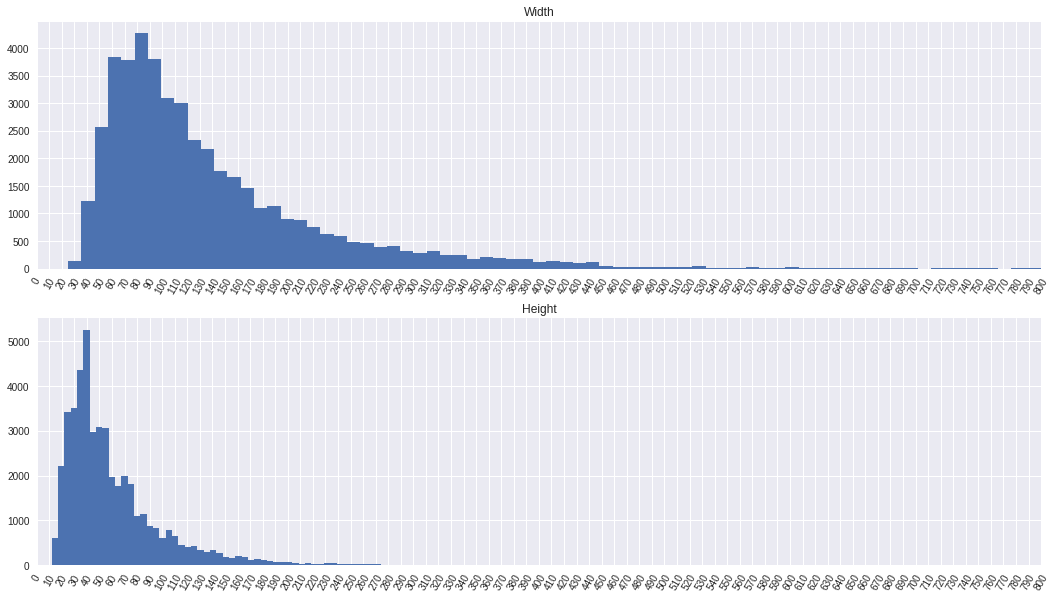

In [ ]:
def PlotImageSizeHist(dirs):
    widths = []
    heights = []
    for dir in dirs:
        paths = glob.glob(os.path.join(dir, '*.png'))
        for path in paths:
            width, height = imagesize.get(path)
            widths.append(width)
            heights.append(height)
    
    plt.figure(figsize=(18, 10))
    plt.subplot(211); plt.hist(widths, 100); plt.title("Width"); plt.xlim([0, 800]); plt.xticks(range(0, 801, 10), rotation=60)
    plt.subplot(212); plt.hist(heights, 100); plt.title("Height"); plt.xlim([0, 800]); plt.xticks(range(0, 801, 10), rotation=60)
    return widths, heights


widths, heights = PlotImageSizeHist([trainPath, testPath])


In [5]:
def GetDataset(dir, df):
    imgPaths = glob.glob(os.path.join(dir, '*.png'))
    imgIDs = [os.path.split(path)[-1] for path in imgPaths]

    dataset = []
    for imgID in imgIDs:
        imgPath = os.path.join(dir, imgID)
        width, height = imagesize.get(imgPath)

        data = {
            'file_name': imgPath,
            'height': height,
            'width': width
        }

        temp = df[df['img_name'] == imgID]
        bboxes = []
        for i, row in temp.iterrows():
            categoryID = int(row['label']) if int(row['label']) != 10 else 0
            bbox = {
                'bbox': [row['left'], row['top'], row['right'], row['bottom']],
                'bbox_mode': BoxMode.XYXY_ABS,
                'category_id': categoryID,
                'iscrowd': 0
            }
            bboxes.append(bbox)
        
        data['annotations'] = bboxes
        dataset.append(data)
    
    return dataset


def SearchData(imgID, dataset, dir='train'):
    for data in dataset:
        if data['file_name'] == f'{dir}/{imgID}.png':
            return data


In [ ]:
dataset = GetDataset(trainPath, data)
with open(datasetPath, 'wb') as f:
    pickle5.dump(dataset, f)
    

In [6]:
with open(datasetPath, 'rb') as f:
    dataset = pickle5.load(f)

dataset

[{'annotations': [{'bbox': [31.0, 5.0, 43.0, 30.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 6,
    'iscrowd': 0},
   {'bbox': [45.0, 9.0, 58.0, 34.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0,
    'iscrowd': 0}],
  'file_name': 'train/20356.png',
  'height': 45,
  'width': 91},
 {'annotations': [{'bbox': [13.0, 6.0, 21.0, 17.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 2,
    'iscrowd': 0}],
  'file_name': 'train/4275.png',
  'height': 21,
  'width': 45},
 {'annotations': [{'bbox': [32.0, 8.0, 43.0, 38.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 4,
    'iscrowd': 0},
   {'bbox': [44.0, 8.0, 58.0, 38.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 4,
    'iscrowd': 0}],
  'file_name': 'train/10680.png',
  'height': 44,
  'width': 90},
 {'annotations': [{'bbox': [15.0, 2.0, 21.0, 18.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 1,
    'iscrowd': 0},
   {'bbox': [20.0, 2.0, 31.0, 18

In [7]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        augmentations = [
            T.RandomBrightness(0.6, 1.4),
            T.RandomContrast(0.6, 1.4),
            T.RandomSaturation(0.6, 1.4),
            T.RandomRotation(angle=[-60, 60]),
            T.RandomLighting(0.7)
        ]
        
        mapper = DatasetMapper(cfg, is_train=True, augmentations=augmentations)
        return build_detection_train_loader(cfg, mapper=mapper)


DatasetCatalog.register(trainPath, lambda: dataset)
MetadataCatalog.get(trainPath).thing_classes = [str(i) for i in range(10)]

metaData = MetadataCatalog.get(trainPath)


In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.DATASETS.TRAIN = (trainPath,)
cfg.DATASETS.TEST = ()
cfg.INPUT.CROP.ENABLED = True
cfg.INPUT.CROP.SIZE = [0.7, 0.7]
cfg.DATALOADER.NUM_WORKERS = 1
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 50000
# cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 10000
cfg.SOLVER.WARMUP_FACTOR = 1./10000
cfg.SOLVER.STEPS = (15000, 20000, 25000, 30000, 35000, 40000, 45000)
cfg.SOLVER.GAMMA = 0.5
cfg.SOLVER.CHECKPOINT_PERIOD = 50
cfg.SOLVER.NESTEROV = True
cfg.MODEL.ROI_HEADS.NUM_CLASSES = data['label'].unique().shape[0]
cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING = 'range'
cfg.INPUT.MAX_SIZE_TRAIN = 200
cfg.INPUT.MIN_SIZE_TRAIN = (80, 130)
cfg.INPUT.MAX_SIZE_TEST = 200
cfg.INPUT.MIN_SIZE_TEST = (80, 130)
cfg.TEST.DETECTIONS_PER_IMAGE = 100

pprint.pprint(cfg)


{'CUDNN_BENCHMARK': False,
 'DATALOADER': {'ASPECT_RATIO_GROUPING': True,
                'FILTER_EMPTY_ANNOTATIONS': True,
                'NUM_WORKERS': 1,
                'REPEAT_THRESHOLD': 0.0,
                'SAMPLER_TRAIN': 'TrainingSampler'},
 'DATASETS': {'PRECOMPUTED_PROPOSAL_TOPK_TEST': 1000,
              'PRECOMPUTED_PROPOSAL_TOPK_TRAIN': 2000,
              'PROPOSAL_FILES_TEST': (),
              'PROPOSAL_FILES_TRAIN': (),
              'TEST': (),
              'TRAIN': ('train',)},
 'GLOBAL': CfgNode({'HACK': 1.0}),
 'INPUT': {'CROP': {'ENABLED': True,
                    'SIZE': [0.7, 0.7],
                    'TYPE': 'relative_range'},
           'FORMAT': 'BGR',
           'MASK_FORMAT': 'polygon',
           'MAX_SIZE_TEST': 200,
           'MAX_SIZE_TRAIN': 200,
           'MIN_SIZE_TEST': (80, 130),
           'MIN_SIZE_TRAIN': (80, 130),
           'MIN_SIZE_TRAIN_SAMPLING': 'range',
           'RANDOM_FLIP': 'horizontal'},
 'MODEL': {'ANCHOR_GENERATOR': {'ANG

In [9]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=True)

[11/21 13:41:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [10]:
trainer.train()

[11/21 13:41:14 d2.engine.train_loop]: Starting training from iteration 39450


/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:217: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[11/21 13:41:21 d2.utils.events]:  eta: 1:56:16  iter: 39459  total_loss: 0.1549  loss_cls: 0.04802  loss_box_reg: 0.08531  loss_rpn_cls: 0.001323  loss_rpn_loc: 0.007257  time: 0.6910  data_time: 0.5250  lr: 0.000625  max_mem: 2029M
[11/21 13:41:36 d2.utils.events]:  eta: 2:01:57  iter: 39479  total_loss: 0.1615  loss_cls: 0.04935  loss_box_reg: 0.08802  loss_rpn_cls: 0.001761  loss_rpn_loc: 0.01289  time: 0.7056  data_time: 0.5514  lr: 0.000625  max_mem: 2517M
[11/21 13:41:52 d2.utils.events]:  eta: 1:53:59  iter: 39499  total_loss: 0.1579  loss_cls: 0.05026  loss_box_reg: 0.0785  loss_rpn_cls: 0.003743  loss_rpn_loc: 0.01343  time: 0.6705  data_time: 0.4744  lr: 0.000625  max_mem: 2517M
[11/21 13:42:05 d2.utils.events]:  eta: 1:51:30  iter: 39519  total_loss: 0.1643  loss_cls: 0.04892  loss_box_reg: 0.08317  loss_rpn_cls: 0.001393  loss_rpn_loc: 0.01016  time: 0.6644  data_time: 0.4814  lr: 0.000625  max_mem: 2517M
[11/21 13:42:20 d2.utils.events]:  eta: 1:52:36  iter: 39539  total_

In [ ]:
cfg.MODEL.WEIGHTS = "model/faster_rcnn_X_101_32x8d_FPN_3x__loss0.12.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

In [ ]:
def Predict(predictor, imgID, showImage=True):
    testImg = TestImage(imgID)
    pred = predictor(testImg)
    if showImage:
        v = Visualizer(testImg[:, :, ::-1], metadata=metaData)
        v = v.draw_instance_predictions(pred["instances"].to("cpu"))

        plt.figure(figsize=(testImg.shape[0]//5, testImg.shape[1]//10))
        plt.subplot(121); plt.imshow(v.get_image())
        plt.subplot(122); plt.imshow(testImg[:, :, ::-1])
        plt.show()

        pprint.pprint(pred)
    
    return pred


def GetBBoxes(pred):
    bboxes = pred['instances'].get_fields()['pred_boxes'].tensor.to('cpu').numpy().copy()
    bboxes[:, [0, 1, 2, 3]] = bboxes[:, [1, 0, 3, 2]]
    return [tuple(bbox) for bbox in bboxes.tolist()]


def GetScores(pred):
    scores = pred['instances'].get_fields()['scores'].to('cpu').numpy().copy()
    return scores.tolist()


def GetLabels(pred):
    labels = pred['instances'].get_fields()['pred_classes'].to('cpu').numpy().copy()
    return labels.tolist()


def DumpResultsToJSON(predictor, dir=testPath, save=True, jsonName='309612092.json'):
    testImgs = glob.glob(os.path.join(dir, '*.png'))
    testImgs = sorted(testImgs, key=lambda x: int(os.path.split(x)[-1].replace('.png', '')))
    results = []
    print(f"Start predicting all images in [{dir}]...")
    for testImg in tqdm(testImgs):
        imgID = int(os.path.split(testImg)[-1].replace('.png', ''))
        pred = Predict(predictor, imgID, False)
        result = {
            "bbox": GetBBoxes(pred),
            "score": GetScores(pred),
            "label": GetLabels(pred)
        }
        results.append(result)
    
    if save:
        print(f"Dumping the JSON file: [{jsonName}] ...")
        with open(jsonName, 'w', encoding='utf-8') as f:
            json.dump(results, f, ensure_ascii=False)
    
    print("Done!")
    return results


def ShowPredictImages(predictor, num, maxID=13068):
  for i in range(num):
    print('='*100)
    imgID = random.randint(1, maxID)
    print(f'[{imgID}.png]: \n')
    Predict(predictor, imgID)
    print('\n')



[737.png]: 



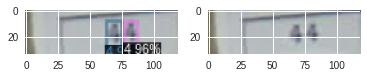

{'instances': Instances(num_instances=2, image_height=34, image_width=119, fields=[pred_boxes: Boxes(tensor([[62.7334,  8.2834, 74.5987, 28.1810],
        [76.7213,  7.5121, 86.9359, 25.5692]], device='cuda:0')), scores: tensor([0.9833, 0.9559], device='cuda:0'), pred_classes: tensor([4, 4], device='cuda:0')])}


[9384.png]: 



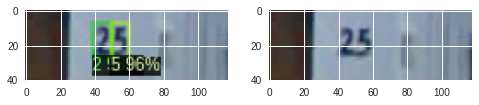

{'instances': Instances(num_instances=2, image_height=41, image_width=118, fields=[pred_boxes: Boxes(tensor([[39.4786,  7.5008, 49.9641, 27.0556],
        [49.7789,  7.4502, 60.0631, 27.2843]], device='cuda:0')), scores: tensor([0.9832, 0.9556], device='cuda:0'), pred_classes: tensor([2, 5], device='cuda:0')])}


[3264.png]: 



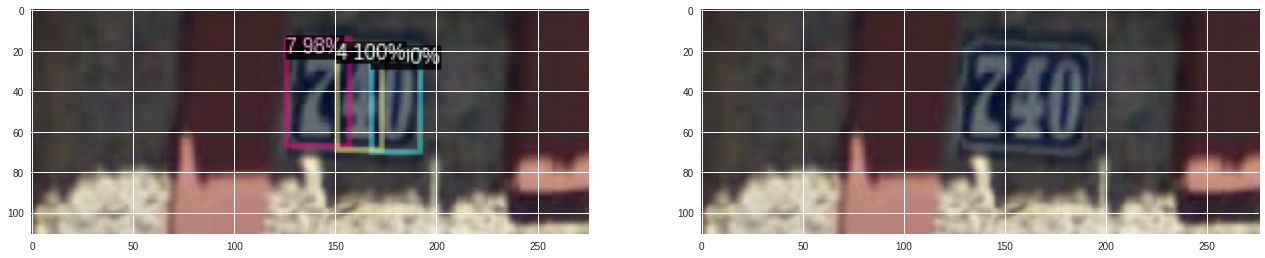

{'instances': Instances(num_instances=3, image_height=111, image_width=276, fields=[pred_boxes: Boxes(tensor([[168.3614,  18.9490, 192.4363,  69.9858],
        [151.4345,  16.6439, 173.4508,  69.0371],
        [126.4180,  13.8201, 156.4993,  67.3948]], device='cuda:0')), scores: tensor([0.9986, 0.9976, 0.9783], device='cuda:0'), pred_classes: tensor([0, 4, 7], device='cuda:0')])}


[9591.png]: 



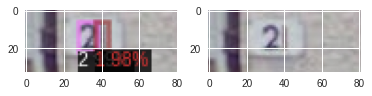

{'instances': Instances(num_instances=2, image_height=33, image_width=81, fields=[pred_boxes: Boxes(tensor([[28.4115,  6.0665, 38.4627, 22.4690],
        [37.4568,  5.8383, 43.8998, 22.0104]], device='cuda:0')), scores: tensor([0.9876, 0.9791], device='cuda:0'), pred_classes: tensor([2, 1], device='cuda:0')])}


[174.png]: 



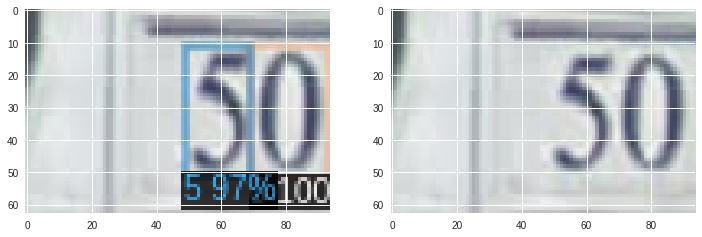

{'instances': Instances(num_instances=2, image_height=63, image_width=94, fields=[pred_boxes: Boxes(tensor([[69.1965, 10.7126, 93.2690, 51.6350],
        [48.5227, 11.1730, 69.2154, 50.8285]], device='cuda:0')), scores: tensor([0.9960, 0.9701], device='cuda:0'), pred_classes: tensor([0, 5], device='cuda:0')])}




In [ ]:
ShowPredictImages(predictor, 5)

In [ ]:
res = DumpResultsToJSON(predictor, testPath)

Start predicting all images in [test]...



Dumping the JSON file: [309612092.json] ...
Done!


In [ ]:
res

[{'bbox': [[9.016040802001953,
    112.83544921875,
    43.15707015991211,
    139.3574676513672]],
  'label': [3],
  'score': [0.997829258441925]},
 {'bbox': [[8.336657524108887,
    50.70281982421875,
    31.02371597290039,
    64.94564819335938],
   [8.800966262817383,
    35.69965362548828,
    31.567956924438477,
    51.185150146484375]],
  'label': [0, 9],
  'score': [0.989000141620636, 0.9884421229362488]},
 {'bbox': [[12.8209810256958,
    66.32666778564453,
    45.880531311035156,
    92.12472534179688],
   [38.256649017333984,
    69.23118591308594,
    55.23201370239258,
    79.48065185546875]],
  'label': [4, 1],
  'score': [0.940310001373291, 0.55909663438797]},
 {'bbox': [[8.356181144714355,
    88.56536102294922,
    45.47819900512695,
    111.4053726196289],
   [7.585343360900879,
    64.89017486572266,
    42.78737258911133,
    87.90721893310547],
   [8.109951972961426,
    47.23807907104492,
    40.57050323486328,
    64.07683563232422]],
  'label': [9, 9, 1],
  'sco

In [ ]:
img = TestImage(10)

In [ ]:
%%timeit
predictor(img)

10 loops, best of 3: 32.2 ms per loop
